In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 124.9/124.9 MB 7.5 MB/s eta 0:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

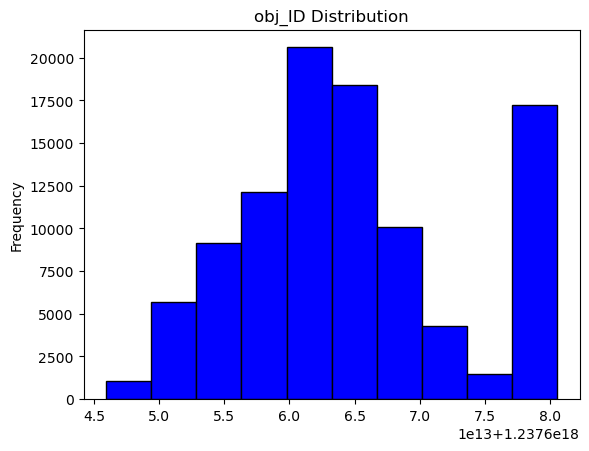

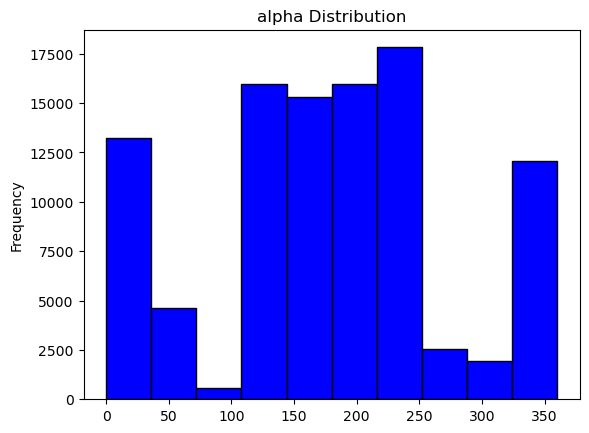

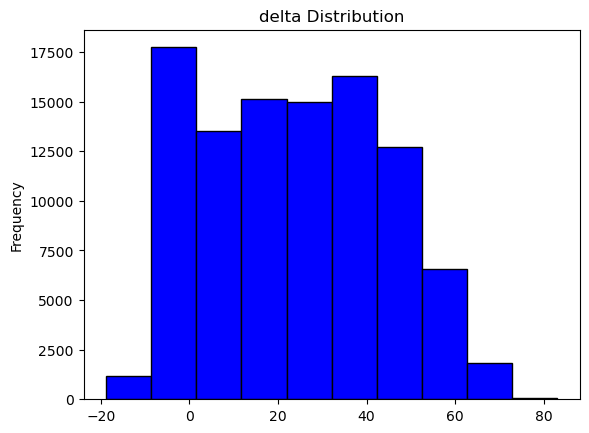

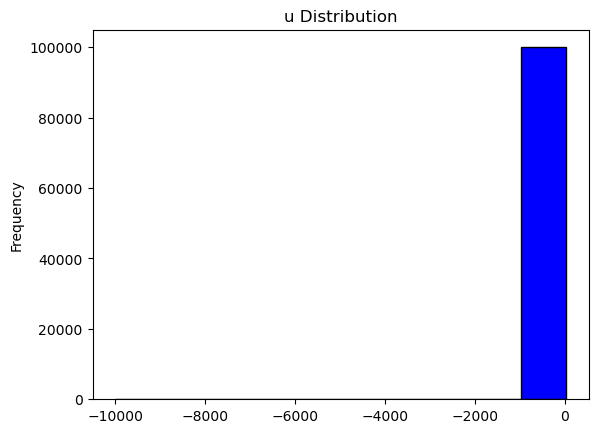

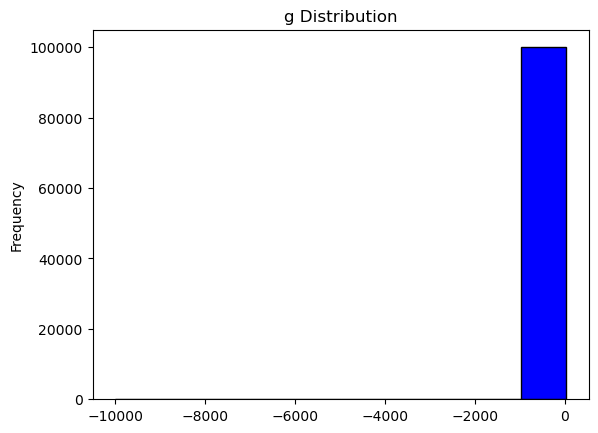

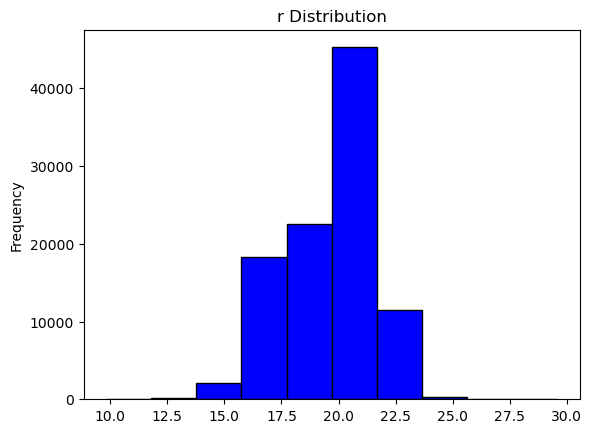

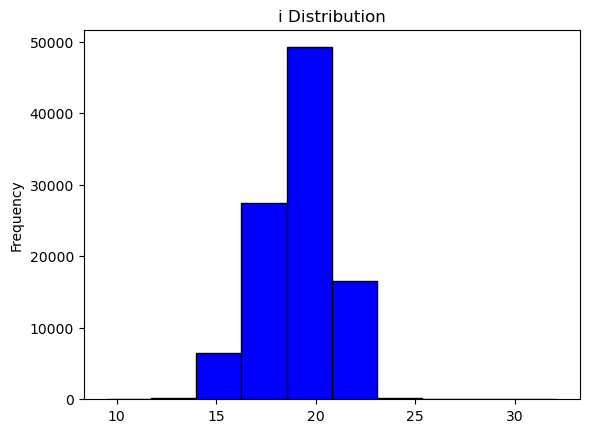

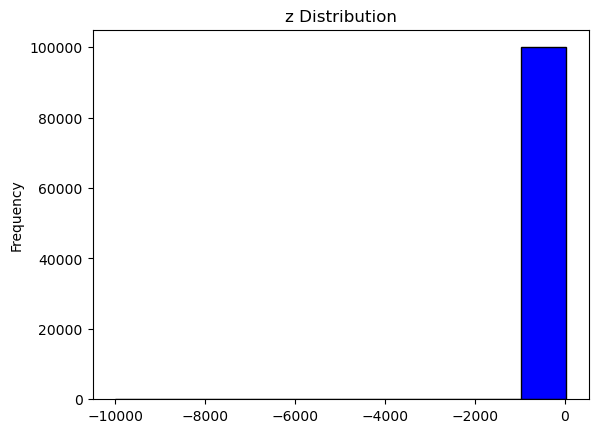

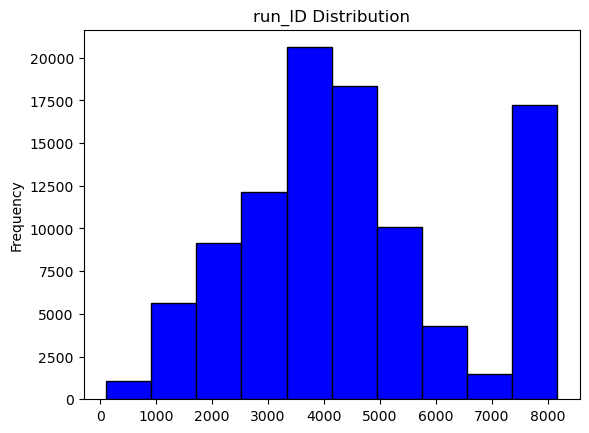

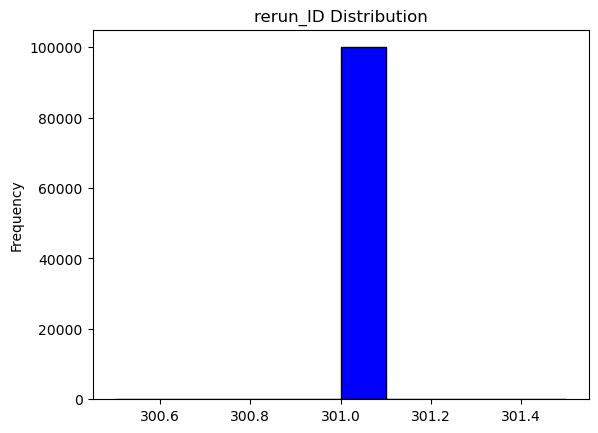

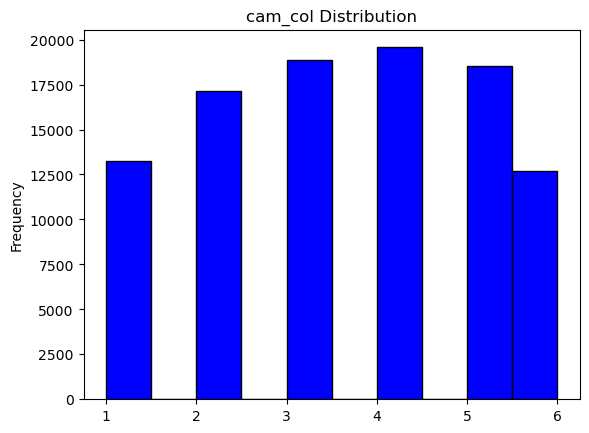

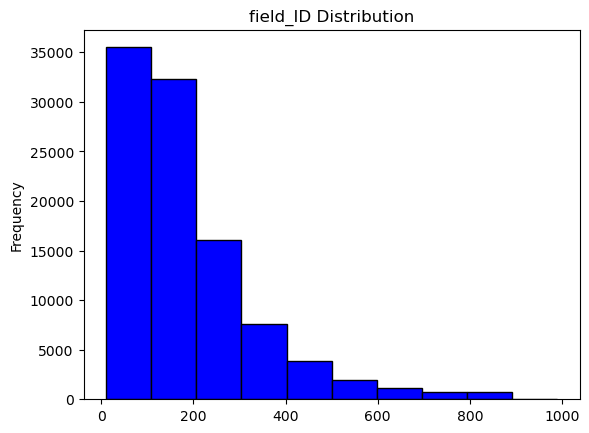

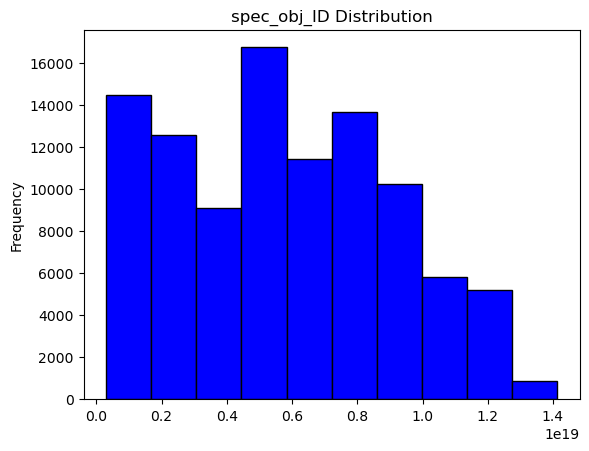

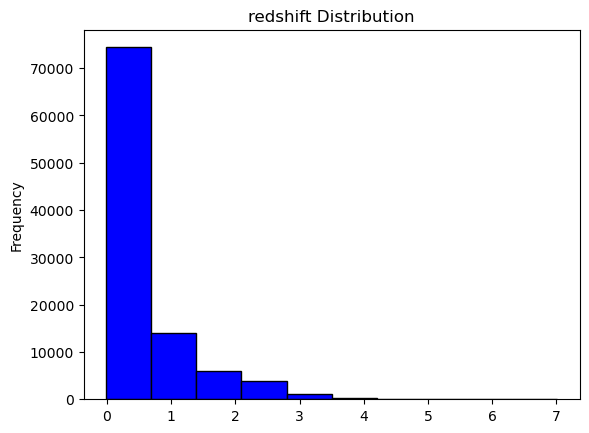

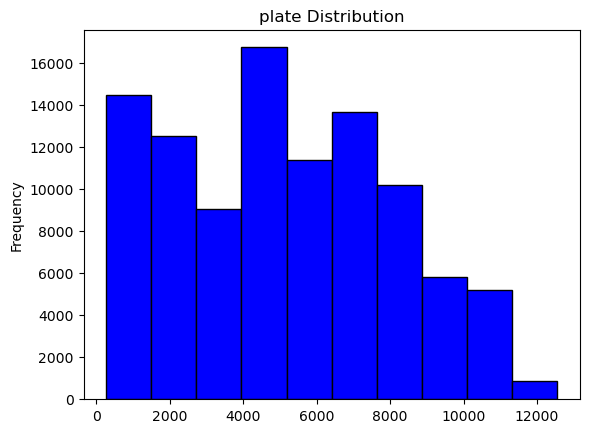

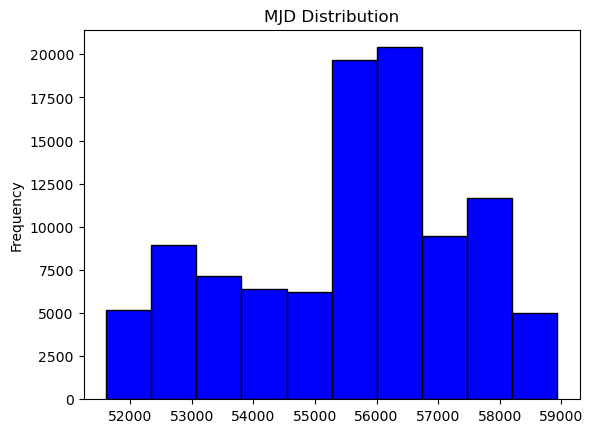

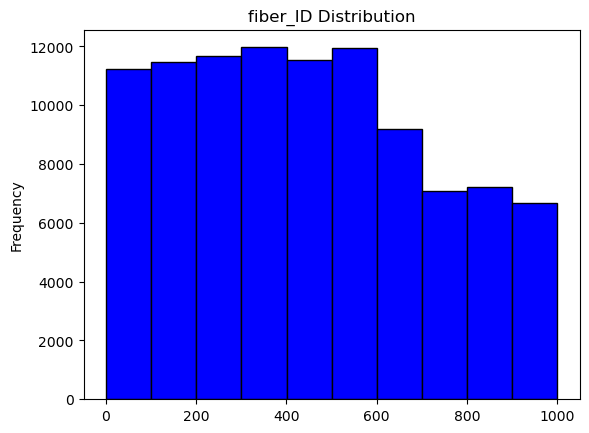

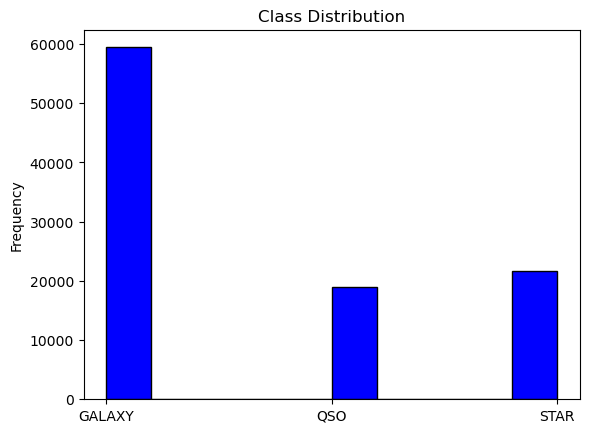

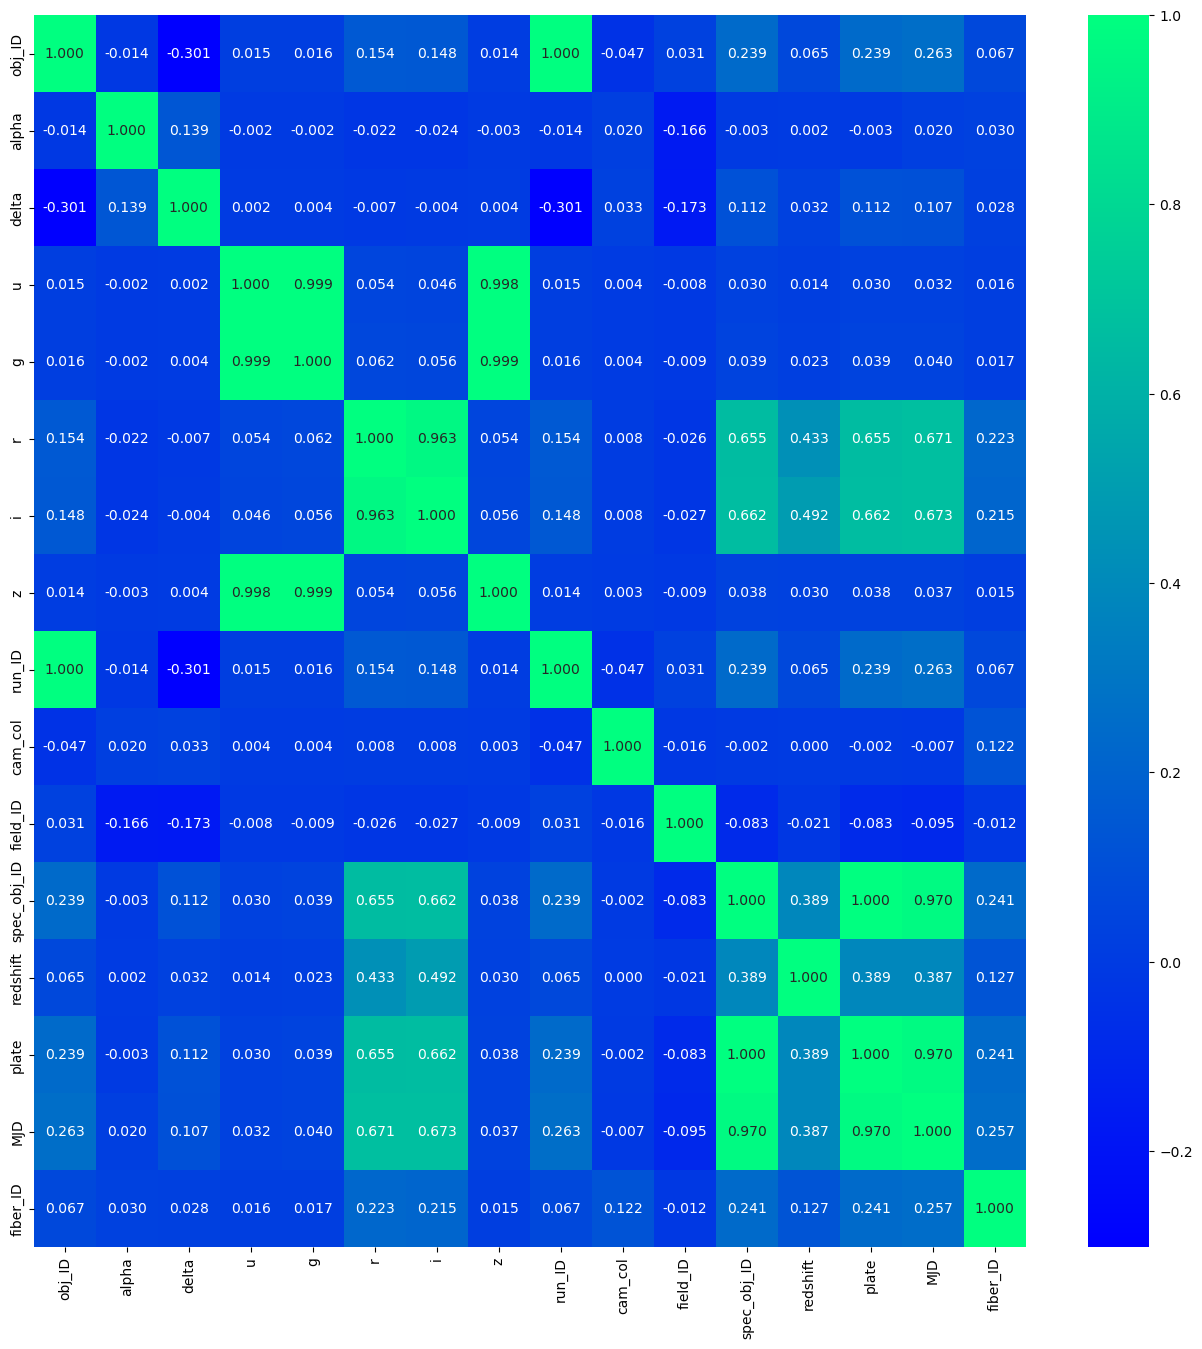

In [2]:
df = pd.read_csv("Stellar Classification Dataset - SDSS17/star_classification.csv")
print(df.info())
print(df.describe())
print(df.head())
for esh in df.columns:
    if esh != "class":
        df[esh].plot(kind="hist", title = f"{esh} Distribution", colormap = "winter", edgecolor="black" )
        plt.show()
plt.hist(df["class"], color="blue", edgecolor="black")
plt.title("Class Distribution")
plt.ylabel("Frequency")
plt.show()
plt.figure(figsize=(16, 16))
sns.heatmap(df.drop("rerun_ID", axis=1).corr(), annot=True, cmap="winter", fmt=".3f" )
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]
x = df.drop("class", axis = 1)
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
y = df["class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05, random_state = 1)

In [3]:
rf = RandomForestClassifier(random_state=1)
parameter_grid = {
    "n_estimators": [10, 50, 100],
    "criterion": ["gini", "entropy"],
    #"max_depth": [None, 10, 25, 50],
    #"min_samples_split": [2, 5, 10],
    #"min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None] 
}
gs = GridSearchCV(estimator=rf, param_grid=parameter_grid, cv=5, n_jobs=-1, verbose=4)
gs.fit(x_train, y_train)
print("Best parameters found: ", gs.best_params_)
y_pred = gs.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found:  {'criterion': 'entropy', 'max_features': None, 'n_estimators': 100}
Accuracy: 0.9822


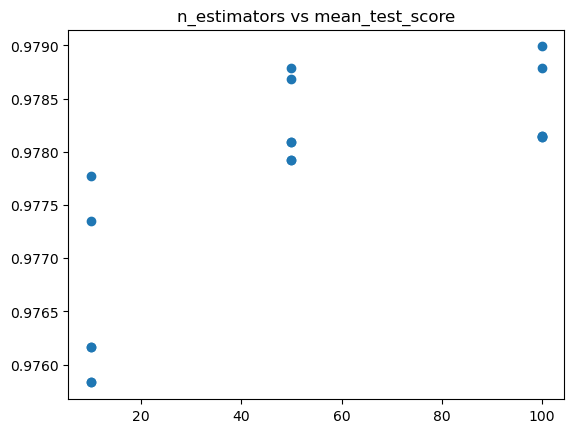

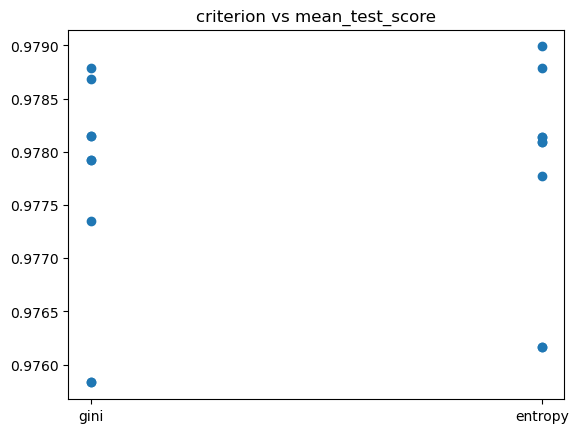

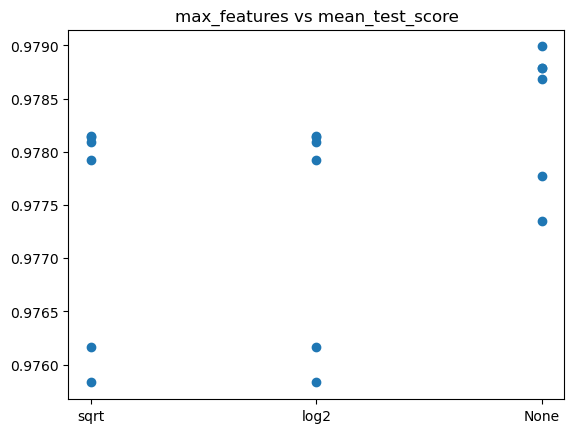

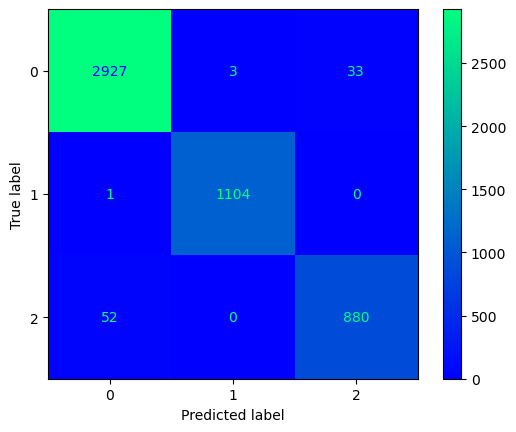

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2963
           1       1.00      1.00      1.00      1105
           2       0.96      0.94      0.95       932

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



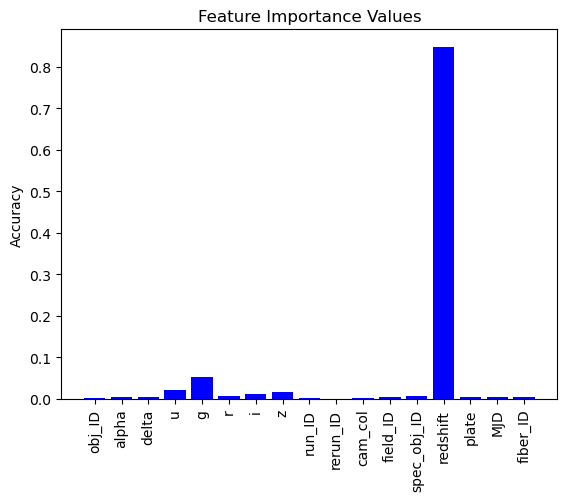

Accuracy: 0.809


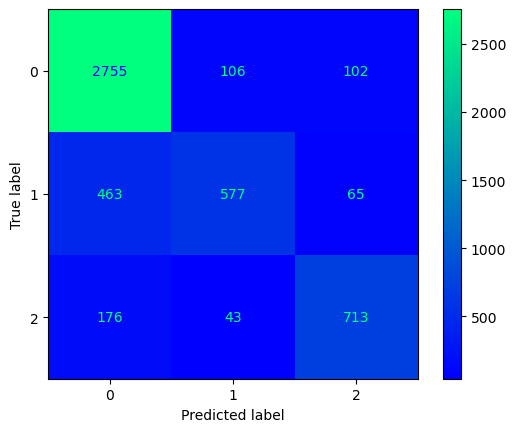

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2963
           1       0.79      0.52      0.63      1105
           2       0.81      0.77      0.79       932

    accuracy                           0.81      5000
   macro avg       0.81      0.74      0.76      5000
weighted avg       0.81      0.81      0.80      5000



In [4]:
n_estimators = [parameter['n_estimators'] for parameter in gs.cv_results_['params']]
criterion = [parameter['criterion'] for parameter in gs.cv_results_['params']]
max_features = [parameter['max_features'] for parameter in gs.cv_results_['params']]
mean_test_scores = gs.cv_results_['mean_test_score']
plt.scatter(n_estimators, mean_test_scores)
plt.title("n_estimators vs mean_test_score")
plt.show()
plt.scatter(criterion, mean_test_scores)
plt.title("criterion vs mean_test_score")
plt.show()
for esh in range(len(max_features)):
    if max_features[esh] == None:
        max_features[esh] = "None"
plt.scatter(max_features, mean_test_scores)
plt.title("max_features vs mean_test_score")
plt.show()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels = gs.classes_, cmap = 'winter')
plt.show()
print(classification_report(y_test, y_pred))
importance_values = gs.best_estimator_.feature_importances_
plt.bar(range(len(importance_values)), importance_values, color="blue")
plt.xticks(range(len(importance_values)),df.drop("class", axis = 1).columns, rotation='vertical')
plt.ylabel("Accuracy")
plt.title("Feature Importance Values")
plt.show()
pca = PCA(n_components = 5)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
rf_pca = RandomForestClassifier(n_estimators=gs.best_params_["n_estimators"], criterion = gs.best_params_["criterion"], max_features = gs.best_params_["max_features"], random_state = 1)
rf_pca.fit(x_train_pca, y_train)
y_pred_pca = rf_pca.predict(x_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print('Accuracy:', accuracy_pca)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca, labels = rf_pca.classes_, cmap = 'winter')
plt.show()
print(classification_report(y_test, y_pred_pca))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'covariance_type': 'spherical', 'n_components': 3}
Accuracy: 0.2998


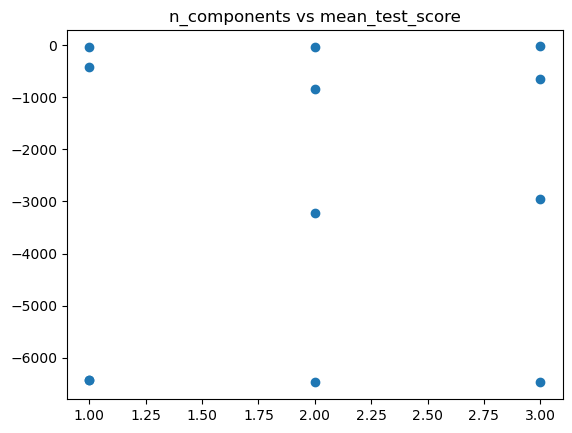

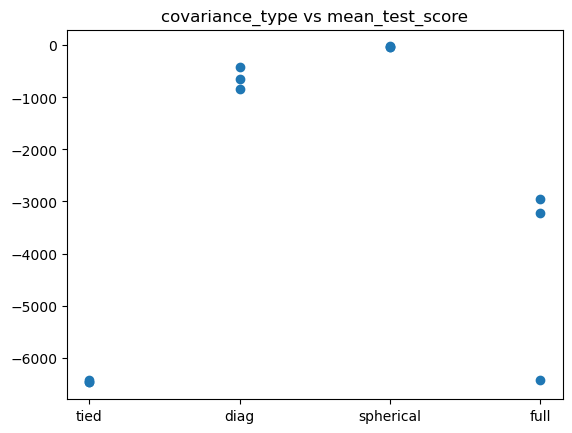

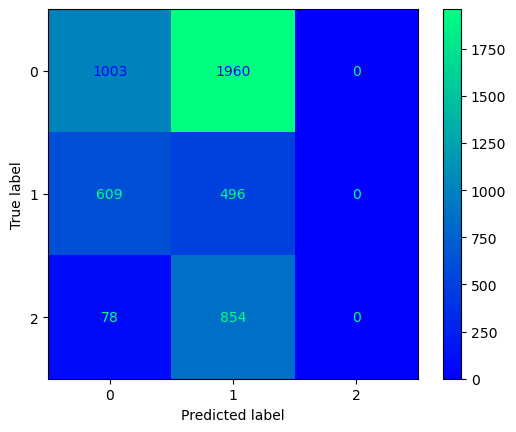

              precision    recall  f1-score   support

           0       0.59      0.34      0.43      2963
           1       0.15      0.45      0.22      1105
           2       0.00      0.00      0.00       932

    accuracy                           0.30      5000
   macro avg       0.25      0.26      0.22      5000
weighted avg       0.38      0.30      0.31      5000

Accuracy: 0.3008


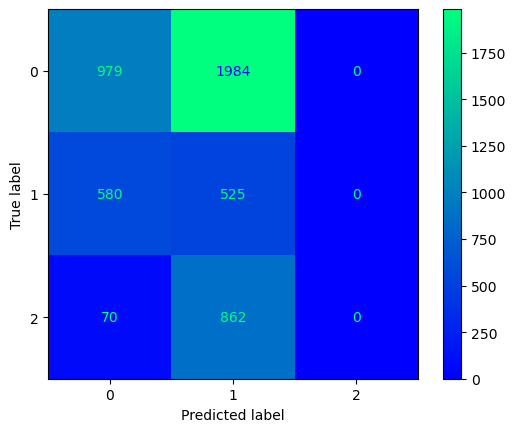

              precision    recall  f1-score   support

           0       0.60      0.33      0.43      2963
           1       0.16      0.48      0.23      1105
           2       0.00      0.00      0.00       932

    accuracy                           0.30      5000
   macro avg       0.25      0.27      0.22      5000
weighted avg       0.39      0.30      0.30      5000

0    18961
1    18961
2    18961
Name: class, dtype: int64
Accuracy: 0.2541747231499385


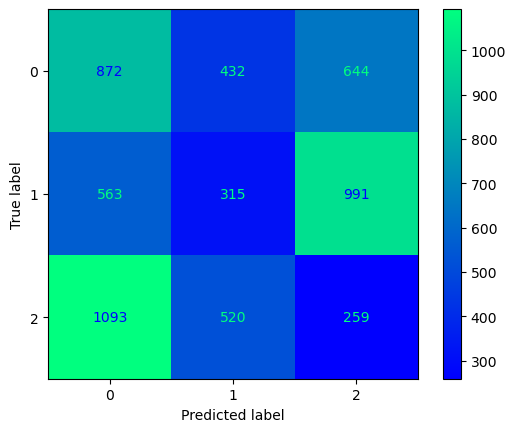

              precision    recall  f1-score   support

           0       0.34      0.45      0.39      1948
           1       0.25      0.17      0.20      1869
           2       0.14      0.14      0.14      1872

    accuracy                           0.25      5689
   macro avg       0.24      0.25      0.24      5689
weighted avg       0.24      0.25      0.24      5689



In [5]:
gmm = GaussianMixture(random_state=1)
parameter_grid = {
    "n_components": [1,2,3],
    "covariance_type": ["tied", "diag", "spherical", "full"],
    #"init_params": ["k-means++"]
}
gs_gmm = GridSearchCV(estimator=gmm, param_grid=parameter_grid, cv=5, n_jobs=-1, verbose=4)
gs_gmm.fit(x_train, y_train)
print("Best parameters found: ", gs_gmm.best_params_)
y_pred_gmm = gs_gmm.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_gmm)
print('Accuracy:', accuracy)
n_components = [parameter['n_components'] for parameter in gs_gmm.cv_results_['params']]
covariance_type = [parameter['covariance_type'] for parameter in gs_gmm.cv_results_['params']]
mean_test_scores = gs_gmm.cv_results_['mean_test_score']
plt.scatter(n_components, mean_test_scores)
plt.title("n_components vs mean_test_score")
plt.show()
plt.scatter(covariance_type, mean_test_scores)
plt.title("covariance_type vs mean_test_score")
plt.show()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gmm, labels = gs.classes_, cmap = 'winter')
plt.show()
print(classification_report(y_test, y_pred_gmm))
pca = PCA(n_components = 2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
gmm_pca = GaussianMixture(n_components=gs_gmm.best_params_["n_components"], covariance_type = gs_gmm.best_params_["covariance_type"], random_state = 1)
gmm_pca.fit(x_train_pca, y_train)
y_pred_pca_gmm = gmm_pca.predict(x_test_pca)
accuracy_pca_gmm = accuracy_score(y_test, y_pred_pca_gmm)
print('Accuracy:', accuracy_pca_gmm)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca_gmm, labels = gs.classes_, cmap = 'winter')
plt.show()
print(classification_report(y_test, y_pred_pca_gmm))
x2 = x.copy()
y2 = y.copy()
undersampler = RandomUnderSampler(random_state=1)
x_balanced, y_balanced = undersampler.fit_resample(x2, y2)
print(y_balanced.value_counts())
x_train_balanced, x_test_balanced, y_train_balanced, y_test_balanced = train_test_split(x_balanced, y_balanced, test_size = 0.1, random_state = 1)
gmm_balanced = GaussianMixture(n_components=gs_gmm.best_params_["n_components"], covariance_type = gs_gmm.best_params_["covariance_type"], random_state = 1)
gmm_balanced.fit(x_train_balanced, y_train_balanced)
y_pred_balanced = gmm_balanced.predict(x_test_balanced)
accuracy_gmm_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
print('Accuracy:', accuracy_gmm_balanced)
ConfusionMatrixDisplay.from_predictions(y_test_balanced, y_pred_balanced, labels = gs.classes_, cmap = 'winter')
plt.show()
print(classification_report(y_test_balanced, y_pred_balanced))

In [9]:
xgb = XGBClassifier(random_state=1)
parameter_grid = {
    "booster": ["gbtree", "gblinear", "dart"],
    "max_depth": [0, 2, 4],
    "tree_method": ["auto", "exact", "approx"]
}
gs_xgb = GridSearchCV(estimator=xgb, param_grid=parameter_grid, cv=5, n_jobs=-1, verbose=4)
gs_xgb.fit(x_train, y_train)
print("Best parameters found: ", gs_xgb.best_params_)
y_pred_xgb = gs_xgb.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_xgb)
print('Accuracy:', accuracy)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'booster': 'gbtree', 'max_depth': 0, 'tree_method': 'approx'}
Accuracy: 0.983


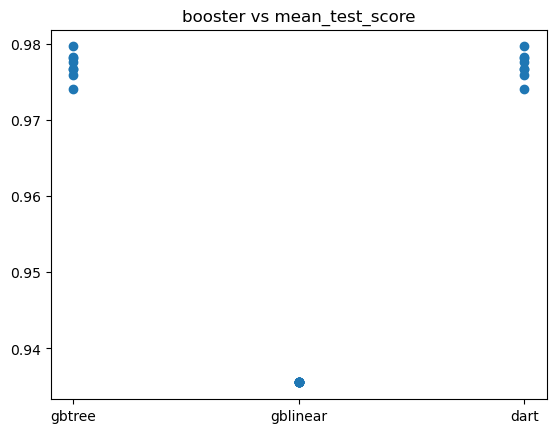

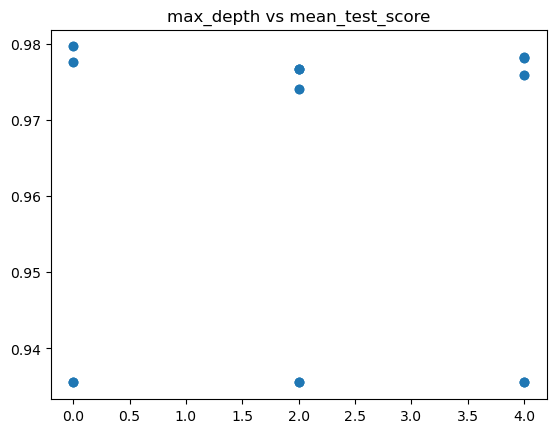

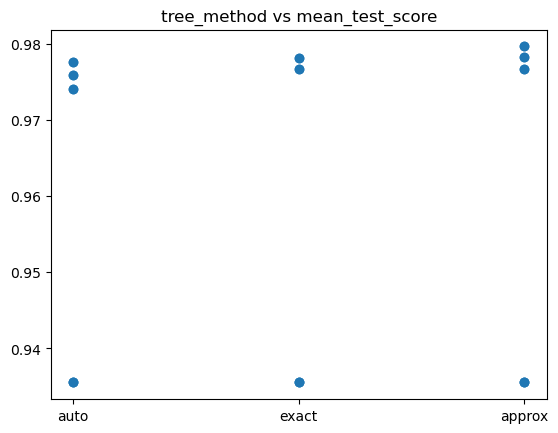

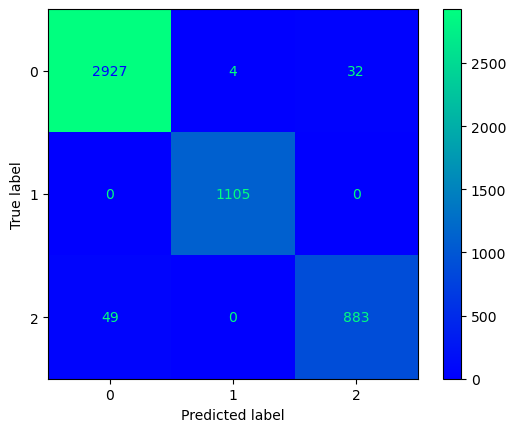

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2963
           1       1.00      1.00      1.00      1105
           2       0.97      0.95      0.96       932

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

Accuracy: 0.811


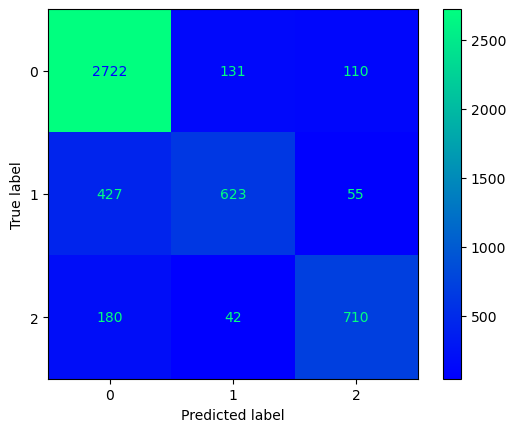

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2963
           1       0.78      0.56      0.66      1105
           2       0.81      0.76      0.79       932

    accuracy                           0.81      5000
   macro avg       0.80      0.75      0.77      5000
weighted avg       0.81      0.81      0.80      5000

Accuracy: 0.9771488838108631


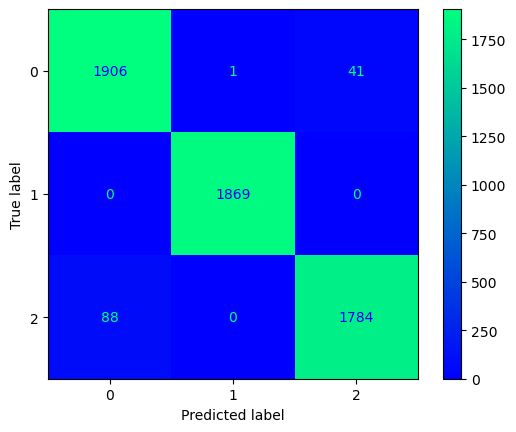

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1948
           1       1.00      1.00      1.00      1869
           2       0.98      0.95      0.97      1872

    accuracy                           0.98      5689
   macro avg       0.98      0.98      0.98      5689
weighted avg       0.98      0.98      0.98      5689



In [13]:
booster = [parameter['booster'] for parameter in gs_xgb.cv_results_['params']]
max_depth = [parameter['max_depth'] for parameter in gs_xgb.cv_results_['params']]
tree_method = [parameter['tree_method'] for parameter in gs_xgb.cv_results_['params']]
mean_test_scores = gs_xgb.cv_results_['mean_test_score']
plt.scatter(booster, mean_test_scores)
plt.title("booster vs mean_test_score")
plt.show()
plt.scatter(max_depth, mean_test_scores)
plt.title("max_depth vs mean_test_score")
plt.show()
plt.scatter(tree_method, mean_test_scores)
plt.title("tree_method vs mean_test_score")
plt.show()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, labels = gs_xgb.classes_, cmap = 'winter')
plt.show()
print(classification_report(y_test, y_pred_xgb))
pca = PCA(n_components = 5)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
xgb_pca = XGBClassifier(booster=gs_xgb.best_params_["booster"], max_depth = gs_xgb.best_params_["max_depth"], tree_method = gs_xgb.best_params_["tree_method"], random_state = 1)
xgb_pca.fit(x_train_pca, y_train)
y_pred_pca_xgb = xgb_pca.predict(x_test_pca)
accuracy_pca_xgb = accuracy_score(y_test, y_pred_pca_xgb)
print('Accuracy:', accuracy_pca_xgb)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca_xgb, labels = xgb_pca.classes_, cmap = 'winter')
plt.show()
print(classification_report(y_test, y_pred_pca_xgb))
xgb_balanced = XGBClassifier(booster=gs_xgb.best_params_["booster"], max_depth = gs_xgb.best_params_["max_depth"], tree_method = gs_xgb.best_params_["tree_method"], random_state = 1)
xgb_balanced.fit(x_train_balanced, y_train_balanced)
y_pred_balanced_xgb = xgb_balanced.predict(x_test_balanced)
accuracy_xgb_balanced = accuracy_score(y_test_balanced, y_pred_balanced_xgb)
print('Accuracy:', accuracy_xgb_balanced)
ConfusionMatrixDisplay.from_predictions(y_test_balanced, y_pred_balanced_xgb, labels = gs_xgb.classes_, cmap = 'winter')
plt.show()
print(classification_report(y_test_balanced, y_pred_balanced_xgb))